## Player Clustering

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set pandas to display all columns
pd.set_option('display.max_columns', None)

# Load the dataset
data = pd.read_csv('enriched_low_elo_games.csv')

# Select features for clustering
features = [
    'white_elo',
    'white_total_wins',
    'white_total_losses',
    'eco',
    'termination'
]

# Create a player-level dataset by aggregating unique White players
player_data = data[features + ['white']].drop_duplicates(subset=['white'])

# Filter eco to top 10 most frequent codes
top_eco = player_data['eco'].value_counts().head(10).index
player_data['eco'] = player_data['eco'].where(player_data['eco'].isin(top_eco), 'other')

# Handle missing values and impute 0s with median for total wins/losses
for col in ['white_total_wins', 'white_total_losses']:
    median_value = player_data[player_data[col] != 0][col].median()
    player_data[col] = player_data[col].replace(0, median_value)
    player_data[col] = player_data[col].fillna(median_value)

# Impute missing white_elo with median
player_data['white_elo'] = player_data['white_elo'].fillna(player_data['white_elo'].median())

# Impute missing categorical values with mode
for col in ['eco', 'termination']:
    player_data[col] = player_data[col].fillna(player_data[col].mode()[0])

# Encode categorical variables
player_data = pd.get_dummies(player_data, columns=['eco', 'termination'], drop_first=True)

# Drop the 'white' column
player_data = player_data.drop(columns=['white'])

# Standardize numerical features
numerical_cols = ['white_elo', 'white_total_wins', 'white_total_losses']
scaler = StandardScaler()
player_data[numerical_cols] = scaler.fit_transform(player_data[numerical_cols])

## Determine optimal number of clusters using elbow method

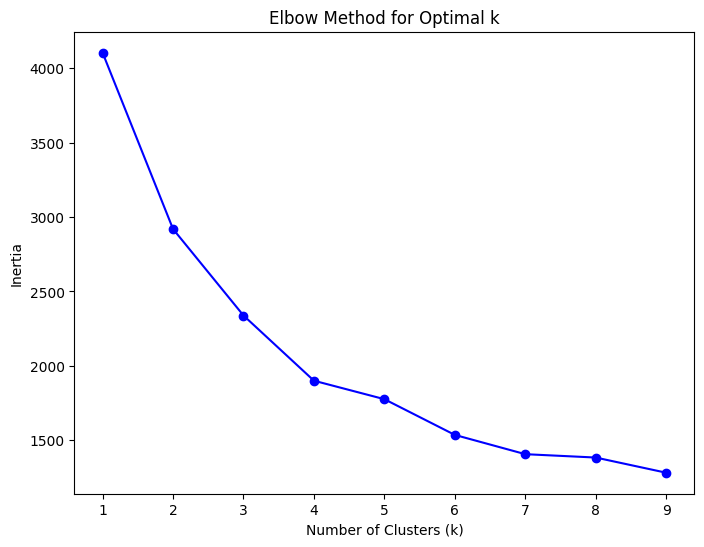

In [2]:
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(player_data)
    inertia.append(kmeans.inertia_)

# Plot elbow curve (to screen)
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

### Apply k-means with chosen number of clusters & Reduce dimensions for visualization using PCA

In [6]:
kmeans = KMeans(n_clusters=4, random_state=42)
player_data['cluster'] = kmeans.fit_predict(player_data)


pca = PCA(n_components=2)
pca_result = pca.fit_transform(player_data.drop(columns=['cluster']))
player_data['pca1'] = pca_result[:, 0]
player_data['pca2'] = pca_result[:, 1]

## Visualize clusters and Analyze 

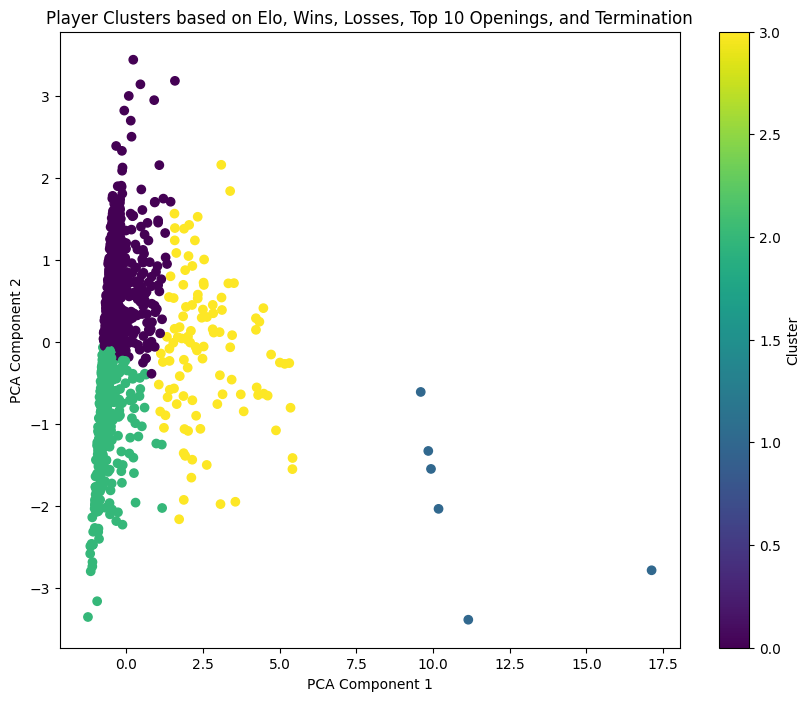

Cluster Summary:
         white_elo  white_total_wins  white_total_losses   eco_A40   eco_B00  \
cluster                                                                        
0         0.616744         -0.231996           -0.236098  0.048964  0.039548   
1        -0.010674          7.458014            8.755894  0.166667  0.000000   
2        -1.010791         -0.342391           -0.298183  0.053073  0.047486   
3         0.327963          1.914459            1.710307  0.019048  0.000000   

          eco_B01   eco_B20   eco_C00   eco_C20   eco_C40   eco_C41   eco_D00  \
cluster                                                                         
0        0.067797  0.028249  0.047081  0.075330  0.052731  0.039548  0.056497   
1        0.000000  0.166667  0.000000  0.000000  0.000000  0.000000  0.000000   
2        0.069832  0.041899  0.030726  0.122905  0.019553  0.039106  0.069832   
3        0.047619  0.019048  0.066667  0.066667  0.000000  0.047619  0.076190   

         eco_ot

In [7]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(player_data['pca1'], player_data['pca2'], c=player_data['cluster'], cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Player Clusters based on Elo, Wins, Losses, Top 10 Openings, and Termination')
plt.colorbar(scatter, label='Cluster')
plt.show()

# Cluster characteristics
cluster_summary = player_data.groupby('cluster').mean()
print("Cluster Summary:")
print(cluster_summary)

# Print column names for reference
print("Columns in cluster_summary:")
print(cluster_summary.columns.tolist())

# Cluster Summary Analysis (Low Elo Players)  

This section analyzes clusters generated from a low-Elo player dataset using standardized features such as Elo rating, win/loss stats, ECO opening codes, and game termination types.

---

## Cluster Overview and Interpretation

### **Cluster 0 – Balanced and Average Play**
- **White Elo**: 0.62 → Slightly above average
- **Wins/Losses**: Slightly negative → Balanced performance
- **Openings**: Diverse (e.g., A40, B00, B01, C20, etc.)
- **Termination**: 
  - Normal: 0.69 (high)
  - Time forfeit: 0.31
- **PCA Components**: 
  - `pca1`: -0.22
  - `pca2`: 0.66
- **Interpretation**:  
  General-purpose players with varied openings and stable gameplay. Neither weak nor strong; average performers.

---

### **Cluster 1 – Outliers with High Activity**
- **White Elo**: -0.01 → Around average
- **Wins**: 7.46, **Losses**: 8.76 → Extremely high counts
- **Openings**: Dominated by B20 and A40
- **Termination**:
  - Normal: 0.50
  - Time forfeit: 0.50
- **PCA Components**: 
  - `pca1`: 11.30 (very high)
  - `pca2`: -1.95
- **Interpretation**:  
  Possibly bots, high-speed players, or erratic users. Narrow opening repertoire and extreme play volume suggest outlier behavior.

---

### **Cluster 2 – Struggling Beginners**
- **White Elo**: -1.01 → Lowest among all clusters
- **Wins/Losses**: Below average in both
- **Openings**: Uses a wide range (e.g., C20, D00) but with little success
- **Termination**:
  - Normal: 0.74 (highest)
  - Time forfeit: 0.26
- **PCA Components**: 
  - `pca1`: -0.61
  - `pca2`: -0.92
- **Interpretation**:  
  Weak players with little experience or success. Often finish games, but struggle overall. Likely casual or new users.

---

### **Cluster 3 – Improving or Intermediate Players**
- **White Elo**: 0.33 → Above average
- **Wins**: 1.91, **Losses**: 1.71 → Positive performance
- **Openings**: More structured (e.g., C00, C20, D00)
- **Termination**:
  - Normal: 0.59
  - Time forfeit: 0.41
- **PCA Components**: 
  - `pca1`: 2.59
  - `pca2`: -0.09
- **Interpretation**:  
  Intermediate-level players showing signs of improvement. Structured strategies and better win/loss balance.

---

## Summary Table

| Cluster | Summary Description            | Key Features                                           |
|---------|--------------------------------|--------------------------------------------------------|
| 0       | Average low-Elo players        | Balanced stats, varied openings, normal game endings   |
| 1       | High-volume/anomalous players | High win/loss counts, narrow openings, extreme PCA     |
| 2       | Struggling beginners          | Low Elo, frequent losses, broad but weak strategies    |
| 3       | Solid/intermediate players    | Better win/loss, structured openings, improving players|

---
